In [293]:
pip install pymorphy3




SyntaxError: invalid syntax (<ipython-input-293-2489c03ad6c6>, line 1)

In [67]:
pip install wordcloud matplotlib

In [132]:
pip install dash plotly pandas

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 32.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 16.4 MB/s eta 0:00:00
  Created wheel for stringcase: filename=stringcase-1.2.0-py3-none-any.whl size=3568 sha256=13402e5721a3ca2e4ff3834eb3da8fef80822a003ff84e1a91dfd86c3095e141
  Stored in directory: /root/.cache/pip/wheels/b4/33/6d/d0820be98063da218c3206fbad2381cd2db3fbb1a0f0d254b5
Successfully built stringcase
  Attempting uninstall: Werkzeug
    Found existing installation: Werkzeug 3.1.3
    Uninstalling Werkzeug-3.1.3:
      Successfully uninstalled Werkzeug-3.1.3
  Attempting uninstall: Flask
    Found existing installation: Flask 3.1.0
    Uninstalling Flask-3.1.0:
      Successfully uninstalled Flask-3.1.0


In [283]:
!pip install pyngrok

In [285]:
import json
import re
import plotly.express as px

from collections import Counter
import nltk
from nltk.corpus import stopwords
import pymorphy3

from wordcloud import WordCloud
import matplotlib.pyplot as plt

import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import pandas as pd

from datetime import datetime

from pyngrok import ngrok

# общая функция для парсинга ТГ каналов

In [294]:

def get_text(message):
    #функция достает текст
    if 'text' not in message:
        return ""

    text = message['text']
    if isinstance(text, str):
        return text.lower()
    elif isinstance(text, list):
        result = []
        for item in text:
            if isinstance(item, dict) and 'text' in item:
                result.append(item['text'])
            elif isinstance(item, str):
                result.append(item)
        return ' '.join(result).lower()
    return ""

#строит график распределения по темам
def analyze_file(file_name, words_postuplenie, words_education, words_promo, name):
    with open(file_name, 'r', encoding='utf-8') as file:
        data = json.load(file)

    total = 0
    polls = 0
    education_count = 0
    postuplenie_count = 0
    promo_count = 0
    used = set()

    # создаем регулярки для всех слов
    regex = {}
    for word in words_postuplenie + words_education + words_promo:
        regex[word] = re.compile(rf"\b{re.escape(word)}\w*\b", re.IGNORECASE)

    for msg in data['messages']:
        if msg['type'] != 'message':
            continue

        text = get_text(msg)
        if not text:
            if 'poll' in msg:
                polls += 1
                used.add(msg['id'])
            continue

        total += 1

        if msg['id'] in used:
            continue

        # поступление
        if any(regex[word].search(text) for word in words_postuplenie):
            postuplenie_count += 1
            used.add(msg['id'])
            continue

        # образовательный контент
        if any(regex[word].search(text) for word in words_education):
            education_count += 1
            used.add(msg['id'])
            continue

        # ПРОМО
        if any(regex[word].search(text) for word in words_promo):
            promo_count += 1
            used.add(msg['id'])
            continue

    other = total - len(used)

    stats = {
        "Поступление": postuplenie_count,
        "Образовательный контент": education_count,
        "ПРОМО": promo_count,
        "Опросы": polls,
        "Остальные посты": other
    }

    #палииииитра
    colors = {
        "Поступление": "#b2f2bb",  # салатовый
        "Образовательный контент": "#a3d8f4",  # голубой
        "ПРОМО": "#ffb3ba",  # розовый
        "Опросы": "#ffdfba",  # жёлтый
        "Остальные посты": "#d3d3d3",  # серый
    }

    #диаграммка
    chart = px.pie(
        names=list(stats.keys()),
        values=list(stats.values()),
        title=f'Посты по категориям в "{name}"',
        hole=0.5,
        color=list(stats.keys()),
        color_discrete_map=colors,
    )

    chart.update_traces(textposition='outside', textinfo='percent+label')
    chart.update_layout(showlegend=True)
    return chart

#считаем всякую статистику про каналы
def calculate_post_stats(file_name):
    with open(file_name, 'r', encoding='utf-8') as file:
        data = json.load(file)

    messages = data.get('messages', [])

    total_posts = 0
    total_words = 0
    date_counts = {}

    for msg in messages:
        if msg['type'] != 'message':
            continue

        text = get_text(msg)
        if not text:
            continue

        total_posts += 1
        total_words += len(text.split())

        date = datetime.fromisoformat(msg['date']).date()
        if date in date_counts:
            date_counts[date] += 1
        else:
            date_counts[date] = 1

    if date_counts:
        total_days = len(date_counts)
        avg_posts_per_day = total_posts / total_days
        avg_posts_per_week = avg_posts_per_day * 7
    else:
        avg_posts_per_day = avg_posts_per_week = 0

    avg_post_length = total_words / total_posts if total_posts > 0 else 0

    return {
        "total_posts": total_posts,
        "avg_posts_per_day": avg_posts_per_day,
        "avg_posts_per_week": avg_posts_per_week,
        "avg_post_length": avg_post_length
    }

def plot_posts_dynamics(file_name):
    with open(file_name, 'r', encoding='utf-8') as file:
        data = json.load(file)

    messages = data.get('messages', [])

    posts_by_month = {}

    for msg in messages:
        if msg['type'] != 'message':
            continue

        text = get_text(msg)
        if not text:
            continue

        date = datetime.fromisoformat(msg['date'])
        year_month = date.strftime('%Y-%m')

        if year_month in posts_by_month:
            posts_by_month[year_month] += 1
        else:
            posts_by_month[year_month] = 1

    df = pd.DataFrame(list(posts_by_month.items()), columns=['Месяц', 'Количество постов'])

    df['Месяц'] = pd.to_datetime(df['Месяц'])
    df = df.sort_values('Месяц')

    #график за все время
    fig_all_time = px.bar(
        df,
        x='Месяц',
        y='Количество постов',
        title='Динамика выхода постов за все время',
        labels={'Месяц': 'Месяц', 'Количество постов': 'Количество постов'},
        text='Количество постов',
        color=df['Месяц'].dt.year.astype(str),
        color_discrete_sequence=px.colors.qualitative.Pastel1
    )

    fig_all_time.add_scatter(
        x=df['Месяц'],
        y=df['Количество постов'].rolling(window=4, center=True).mean(),
        mode='lines',
        line=dict(color='hotpink', width=2, dash='dash'),
        showlegend=False
    )

    ticktext = []
    for date in df['Месяц']:
        if date.month == 1:
            ticktext.append(date.strftime('%Y'))
        elif date.month in [4, 7, 10]:
            ticktext.append(date.strftime('%b'))
        else:
            ticktext.append('')

    fig_all_time.update_xaxes(
        tickvals=df['Месяц'],
        ticktext=ticktext,
        tickangle=45
    )

    fig_all_time.update_traces()
    fig_all_time.show()

    last_year = datetime.now().year - 1
    df_last_year = df[df['Месяц'].dt.year >= last_year]

    #график последний год
    fig_last_year = px.bar(
        df_last_year,
        x='Месяц',
        y='Количество постов',
        title=f'Динамика выхода постов за {last_year} год',
        labels={'Месяц': 'Месяц', 'Количество постов': 'Количество постов'},
        text='Количество постов',
        color=df_last_year['Месяц'].dt.month.astype(str),
        color_discrete_sequence=px.colors.qualitative.Pastel1
    )

    fig_last_year.add_scatter(
        x=df_last_year['Месяц'],
        y=df_last_year['Количество постов'].rolling(window=2, center=True).mean(),
        mode='lines',
        line=dict(color='hotpink', width=2, dash = 'dash'),
        showlegend=False
    )

    fig_last_year.update_xaxes(
        tickformat='%b %Y',
        tickangle=45
    )

    fig_last_year.update_traces()
    return fig_all_time, fig_last_year



# Парсинг Умбрии Олимп

Давайте поймем, что для того, чтобы понять, какие слова использовать, нужно понять, какие вообще есть слова. Найдем 100 самых частых слов, только аккуратно.

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


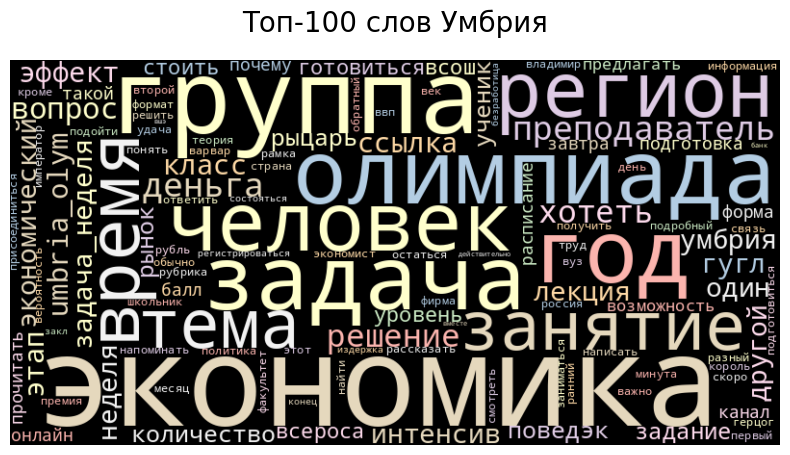

In [295]:

# стоп-слова хехехе
nltk.download('stopwords')
morph = pymorphy3.MorphAnalyzer()
stop_words = set(stopwords.words('russian'))

with open('result.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

all_words = []
for msg in data['messages']:
    if msg['type'] != 'message':
        continue

    text = msg['text']
    if isinstance(text, str):
        text = text.lower()
    elif isinstance(text, list):
        text = ' '.join([item['text'] if isinstance(item, dict) else item for item in text]).lower()

    #разбиваем на слова
    tokens = re.findall(r'\b\w+\b', text)
    filtered = [word for word in tokens if word not in stop_words and len(word) > 2 and not word.isdigit()]
    all_words.extend(filtered)

word_counts = Counter(all_words)

top_words = word_counts.most_common(200)

lemma_counts = Counter()
for word, count in top_words:
    lemma = morph.parse(word)[0].normal_form
    lemma_counts[lemma] += count

# смотрим глазками и выкидываем чушь
exclude = {
    "это", "эта", "эти", "каждый", "также", "свой", "просто", "быть", "однако", "смочь", "ждать", "мочь", "900р",
    "который", "наш", "очень", "поэтому", "сегодня", "всё", "кстати", "например", "тот", "весь", "самый", "именно", "сам",
    "понедельник", "https", "вторник", "среда", "четверг", "пятница", "суббота", "воскресение", "минь", "мы", "ещё",
    "значит", "нужно", "часто", "сделать", "несколько", "давать", "либо", "какой"
}
filtered = {lemma: count for lemma, count in lemma_counts.items() if lemma not in exclude}

# колдуем облако слов
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='black',
    colormap='Pastel1',
    max_words=150,
    contour_width=1,
    contour_color='steelblue'
).generate_from_frequencies(filtered)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Топ-100 слов Умбрия", fontsize=20, pad=20, color='black')
plt.savefig('wordcloud1.png', bbox_inches='tight', pad_inches=0)
plt.show()

In [296]:

postuplenie_keywords = ["поступлени", "поступа", "интервью", "университет", "факультет", "вуз", "бакалавр"]
education_keywords = ["вебинар", "лектори", "совет", "эфир", "рекоменд", "пробн",
                      "разбор", "бесплатн", "поведэк", "нобелевка", "макра", "задача_недели"]
promo_keywords = ["хочу", "зарегистрироваться", "групп", "интенсив", "присоедин",
                  "запис", "узнать подробнее", "готовиться", "регистр", "купить",
                  "получить", "форм", "гугл-форм"]

chart1 = analyze_file('result.json', postuplenie_keywords, education_keywords, promo_keywords, "Умбрия")
chart1.show()
stats = calculate_post_stats('result.json')
print(f"Всего постов - {stats['total_posts']:.1f} постов")
print(f"Средняя длина поста - {stats['avg_post_length']:.1f} слов")
print(f"Частота постов в день - {stats['avg_posts_per_day']:.1f} постов")
print(f"Частота постов в неделю - {stats['avg_posts_per_week']:.1f} постов")

fig_all_time1, fig_last_year1 = plot_posts_dynamics('result.json')
fig_all_time1.show()
fig_last_year1.show()

Всего постов - 262.0 постов
Средняя длина поста - 99.2 слов
Частота постов в день - 1.3 постов
Частота постов в неделю - 8.9 постов


# Парсинг Олмат Экономики

Парсим все слова, убирая незначащие, и находим 100 самых популярных

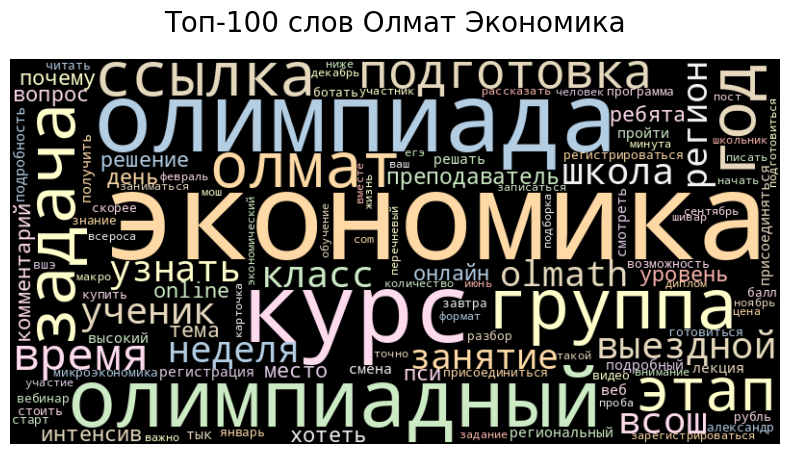

In [255]:


with open('olmath.json', 'r', encoding='utf-8') as f:
    data1 = json.load(f)

all_words = []
for msg in data1['messages']:
    if msg['type'] != 'message':
        continue

    text = msg['text']
    if isinstance(text, str):
        text = text.lower()
    elif isinstance(text, list):
        text = ' '.join([item['text'] if isinstance(item, dict) else item for item in text]).lower()

    #разбиваем на слова
    tokens = re.findall(r'\b\w+\b', text)
    filtered = [word for word in tokens if word not in stop_words and len(word) > 2 and not word.isdigit()]
    all_words.extend(filtered)

word_counts = Counter(all_words)

top_words = word_counts.most_common(200)

lemma_counts = Counter()
for word, count in top_words:
    lemma = morph.parse(word)[0].normal_form
    lemma_counts[lemma] += count

# смотрим глазками и выкидываем чушь
exclude = {
    "это", "эта", "эти", "каждый", "также", "свой", "просто", "быть", "однако", "смочь", "ждать", "мочь", "900р",
    "который", "наш", "очень", "поэтому", "сегодня", "всё", "кстати", "например", "тот", "весь", "самый", "именно", "сам",
    "понедельник", "https", "вторник", "среда", "четверг", "пятница", "суббота", "воскресенье", "минь", "мы", "ещё",
    "значит", "нужно", "часто", "сделать", "несколько", "давать", "либо", "какой"
}
filtered = {lemma: count for lemma, count in lemma_counts.items() if lemma not in exclude}

# колдуем облако слов
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='black',
    colormap='Pastel1',
    max_words=150,
    contour_width=1,
    contour_color='steelblue'
).generate_from_frequencies(filtered)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Топ-100 слов Олмат Экономика", fontsize=20, pad=20, color='black')
plt.savefig('wordcloud2.png', bbox_inches='tight', pad_inches=0)
plt.show()

In [266]:

postuplenie_keywords = ["поступлени", "поступа", "интервью", "университет", "факультет", "вуз", "бакалавр"]
education_keywords = ["вебинар", "лектори", "совет", "эфир", "рекоменд", "пробн", "разбор", "бесплатн"]
promo_keywords = ["хочу", "зарегистрироваться", "курс", "интенсив", "присоедин", "запис",
                  "узнать подробнее", "готовиться", "регистр", "купить", "получить", "форм"]

chart2 = analyze_file('olmath.json', postuplenie_keywords, education_keywords, promo_keywords, "Олмат Экономика")
chart2.show()
stats2 = calculate_post_stats('olmath.json')
print(f"Всего постов - {stats2['total_posts']:.1f} постов")
print(f"Средняя длина поста - {stats2['avg_post_length']:.1f} слов")
print(f"Частота постов в день - {stats2['avg_posts_per_day']:.1f} постов")
print(f"Частота постов в неделю - {stats2['avg_posts_per_week']:.1f} постов")

fig_all_time2, fig_last_year2 = plot_posts_dynamics('olmath.json')
fig_all_time2.show()
fig_last_year2.show()

Всего постов - 1816.0 постов
Средняя длина поста - 127.1 слов
Частота постов в день - 1.7 постов
Частота постов в неделю - 11.7 постов


# Парсинг КСИ образования

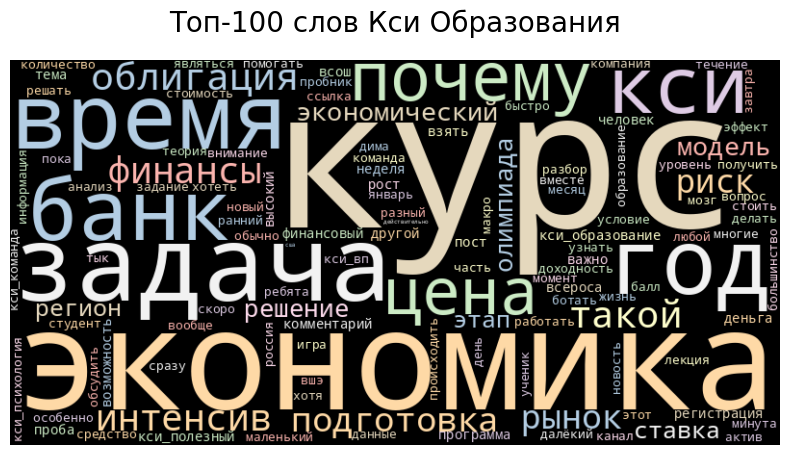

In [297]:

with open('ksi.json', 'r', encoding='utf-8') as f:
    data2 = json.load(f)

all_words = []
for msg in data2['messages']:
    if msg['type'] != 'message':
        continue

    text = msg['text']
    if isinstance(text, str):
        text = text.lower()
    elif isinstance(text, list):
        text = ' '.join([item['text'] if isinstance(item, dict) else item for item in text]).lower()

    #разбиваем на слова
    tokens = re.findall(r'\b\w+\b', text)
    filtered = [word for word in tokens if word not in stop_words and len(word) > 2 and not word.isdigit()]
    all_words.extend(filtered)

word_counts = Counter(all_words)

top_words = word_counts.most_common(200)

lemma_counts = Counter()
for word, count in top_words:
    lemma = morph.parse(word)[0].normal_form
    lemma_counts[lemma] += count

# смотрим глазками и выкидываем чушь
exclude = {
    "это", "эта", "эти", "каждый", "также", "свой", "просто", "быть", "однако",
    "смочь", "ждать", "мочь", "900р",
    "который", "наш", "очень", "поэтому", "сегодня", "всё", "кстати", "например",
    "тот", "весь", "самый", "именно", "сам",
    "понедельник", "https", "вторник", "среда", "четверг", "пятница", "суббота",
    "воскресенье", "минь", "мы", "ещё",
    "значит", "нужно", "часто", "сделать", "несколько", "давать", "либо", "какой"
}
filtered = {lemma: count for lemma, count in lemma_counts.items() if lemma not in exclude}

# колдуем облако слов
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='black',
    colormap='Pastel1',
    max_words=150,
    contour_width=1,
    contour_color='steelblue'
).generate_from_frequencies(filtered)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Топ-100 слов Кси Образования", fontsize=20, pad=20, color='black')
plt.savefig('wordcloud3.png', bbox_inches='tight', pad_inches=0)
plt.show()

In [298]:

postuplenie_keywords = ["поступлени", "поступа", "интервью", "университет",
                        "факультет", "вуз", "бакалавр", "КСИ_поступление"]
education_keywords = ["вебинар", "лектори", "совет", "эфир", "рекоменд", "пробн", "разбор",
                      "КСИ_задача", "КСИ_команда", "КСИ_психология", "КСИ_книг", "КСИ_полезн" ]
promo_keywords = ["хочу", "КСИ_отзывы" "зарегистрироваться", "курс", "интенсив",
                  "присоедин", "запис", "узнать подробнее", "готовиться", "регистр",
                  "купить", "получить", "форм", "КСИ_Взять_Всерос", "КСИ_Взять_Всерос_закл",
                  "КСИ_Финанс", "КСИ_регион", "КСИ_ВП", "КСИ_На_старт"]

chart3 = analyze_file('ksi.json', postuplenie_keywords, education_keywords, promo_keywords, "Кси Образование")
chart3.show()
stats3 = calculate_post_stats('ksi.json')
print(f"Всего постов - {stats3['total_posts']:.1f} поста")
print(f"Средняя длина поста - {stats3['avg_post_length']:.1f} слова")
print(f"Частота постов в день - {stats3['avg_posts_per_day']:.1f} постов")
print(f"Частота постов в неделю - {stats3['avg_posts_per_week']:.1f} постов")

fig_all_time3, fig_last_year3 = plot_posts_dynamics('ksi.json')
fig_all_time3.show()
fig_last_year3.show()

Всего постов - 243.0 поста
Средняя длина поста - 190.0 слова
Частота постов в день - 1.2 постов
Частота постов в неделю - 8.1 постов




# Парсинг экономика с АР

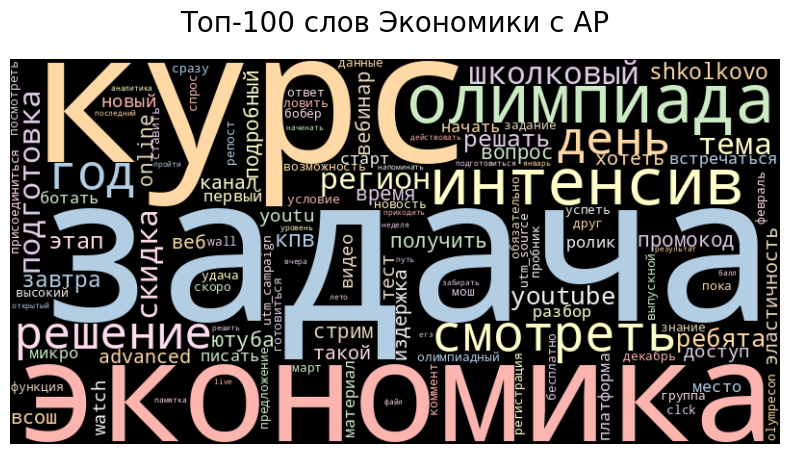

In [299]:

with open('ecoAR.json', 'r', encoding='utf-8') as f:
    data3 = json.load(f)

all_words = []
for msg in data3['messages']:
    if msg['type'] != 'message':
        continue

    text = msg['text']
    if isinstance(text, str):
        text = text.lower()
    elif isinstance(text, list):
        text = ' '.join([item['text'] if isinstance(item, dict) else item for item in text]).lower()

    #разбиваем на слова
    tokens = re.findall(r'\b\w+\b', text)
    filtered = [word for word in tokens if word not in stop_words and len(word) > 2 and not word.isdigit()]
    all_words.extend(filtered)

word_counts = Counter(all_words)

top_words = word_counts.most_common(200)

lemma_counts = Counter()
for word, count in top_words:
    lemma = morph.parse(word)[0].normal_form
    lemma_counts[lemma] += count

# смотрим глазками и выкидываем чушь
exclude = {
    "это", "эта", "эти", "каждый", "также", "свой", "просто", "быть", "однако", "смочь", "ждать", "мочь", "900р",
    "который", "наш", "очень", "поэтому", "сегодня", "всё", "кстати", "например", "тот", "весь", "самый", "именно", "сам",
    "понедельник", "https", "вторник", "среда", "четверг", "пятница", "суббота", "воскресенье", "минь", "мы", "ещё",
    "значит", "нужно", "часто", "сделать", "несколько", "давать", "либо", "какой",
    "ты", "второй", "com", "www"
}
filtered = {lemma: count for lemma, count in lemma_counts.items() if lemma not in exclude}

# колдуем облако слов
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='black',
    colormap='Pastel1',
    max_words=150,
    contour_width=1,
    contour_color='steelblue'
).generate_from_frequencies(filtered)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Топ-100 слов Экономики с АР", fontsize=20, pad=20, color='black')
plt.savefig('wordcloud4.png', bbox_inches='tight', pad_inches=0)
plt.show()

In [300]:

postuplenie_keywords = ["поступлени", "поступа", "интервью", "университет",
                        "факультет", "вуз", "бакалавр", "стажировк"]
education_keywords = [ "практика", "совет", "эфир", "разбор", "смотреть", "разбор",
                      "файл", "памятк", "памят", "смотреть", "задача дня", "решение",
                       "конспект", "дедлайн"]
promo_keywords = ["стоимость", "зарегистрироваться", "курс", "интенсив",
                  "промокод", "скидк", "подробнее", "готовиться", "регистр",
                  "купить", "получить", "начать", "запуск", "запускаем", "действуй",
                  "подключиться", "подключить", "приобрести", "предзапись", "групп",
                  "мини-групп"]

chart4 = analyze_file('ecoAR.json', postuplenie_keywords, education_keywords, promo_keywords, "Экономика с АР")
chart4.show()

stats4 = calculate_post_stats('ecoAR.json')
print(f"Всего постов - {stats4['total_posts']:.1f} постов")
print(f"Средняя длина поста - {stats4['avg_post_length']:.1f} слов")
print(f"Частота постов в день - {stats4['avg_posts_per_day']:.1f} постов")
print(f"Частота постов в неделю - {stats4['avg_posts_per_week']:.1f} постов")

fig_all_time4, fig_last_year4 = plot_posts_dynamics('ecoAR.json')
fig_all_time4.show()
fig_last_year4.show()

Всего постов - 900.0 постов
Средняя длина поста - 27.0 слов
Частота постов в день - 2.1 постов
Частота постов в неделю - 14.6 постов


ну что тут сделать, чел не умеет нормально тг вести, постит ерунду всякую, совсем не наш формат

# Сделаем Дашборд

In [327]:
from pyngrok import ngrok
import socket
from contextlib import closing
ngrok.set_auth_token("2ueY9llsU6fSuwYdijKr9wXtQtJ_6juqfCAw6kdJB77NyHZd")
ngrok.kill()
#тут мне немного помог гпт, потому что у меня все не работало.....((((

def find_free_port():
    with closing(socket.socket(socket.AF_INET, socket.SOCK_STREAM)) as s:
        s.bind(('', 0))
        s.listen(1)
        return s.getsockname()[1]

In [325]:
schools_data = {
    "Умбрия": {
        "description": "Онлайн-школа по олимпиадной экономике ✨ Мы хотим показать, как смотрят на мир экономисты, и помочь вам подготовиться к олимпиадам, чтоб поступить в вуз мечты без вступительных испытаний",
        "subscribers": 700,
        "posts": f"{stats['total_posts']:.1f}",
        "avg_post_length": f"{stats['avg_post_length']:.1f}",
        "post_frequency_day": f"{stats['avg_posts_per_day']:.1f}",
        "post_frequency_week": f"{stats['avg_posts_per_week']:.1f}",
        "all_time": fig_all_time1,
        "last_year": fig_last_year1,
        "theme_pie_chart": chart1
    },
     "Олмат Экономика": {
        "description": "Самое большое сообщество экономистов-олимпиадников. Готовим к олимпиадам по экономике 5-11 классы с любого уровня.",
        "subscribers": 4350,
        "posts": f"{stats2['total_posts']:.1f}",
        "avg_post_length": f"{stats2['avg_post_length']:.1f}",
        "post_frequency_day": f"{stats2['avg_posts_per_day']:.1f}",
        "post_frequency_week": f"{stats2['avg_posts_per_week']:.1f}",
        "all_time": fig_all_time2,
        "last_year": fig_last_year2,
        "theme_pie_chart": chart2
    },
     "Кси Образование": {
        "description": "Привет! Меня зовут Сергей Кыльчик, я выпускник Мехмата МГУ и студент 4 курса МИЭФа ВШЭ, а еще преподаю экономику и математику. Это канал нашего проекта «КСИ - Образование».",
        "subscribers": 1135,
        "posts": f"{stats3['total_posts']:.1f}",
        "avg_post_length": f"{stats3['avg_post_length']:.1f}",
        "post_frequency_day": f"{stats3['avg_posts_per_day']:.1f}",
        "post_frequency_week": f"{stats3['avg_posts_per_week']:.1f}",
        "all_time": fig_all_time3,
        "last_year": fig_last_year3,
        "theme_pie_chart": chart3
    },
     "Экономика с АР": {
        "description": "Канал преподавателя экономики, научу тебя решать даже самые сложные задачи.",
        "subscribers": 1700,
        "posts": f"{stats4['total_posts']:.1f}",
        "avg_post_length": f"{stats4['avg_post_length']:.1f}",
        "post_frequency_day": f"{stats4['avg_posts_per_day']:.1f}",
        "post_frequency_week": f"{stats4['avg_posts_per_week']:.1f}",
        "all_time": fig_all_time4,
        "last_year": fig_last_year4,
        "theme_pie_chart": chart4
    }

}

In [326]:

app = dash.Dash(__name__)

# макетик
app.layout = html.Div([
    dcc.Tabs(id="main-tabs", value="Умбрия", children=[
        dcc.Tab(label="Умбрия", value="Умбрия"),
        dcc.Tab(label="Олмат Экономика", value="Олмат Экономика"),
        dcc.Tab(label="Кси Образование", value="Кси Образование"),
        dcc.Tab(label="Экономика с АР", value="Экономика с АР"),
        dcc.Tab(label="Сравнение школ", value="comparison")
    ]),
    html.Div(id="school-content")
])

# Callback для обновления контента
@app.callback(
    Output("school-content", "children"),
    Input("main-tabs", "value")
)
def render_content(tab):
    if tab == "comparison":
        # Страница сравнения школ
        return html.Div([
            html.H1("Сравнение школ"),
            html.Div([
                html.Div([
                    html.H2(school_name, style={"text-align": "left", "padding-left": "20px"}),
                    html.P(data["description"]),
                    html.P(f"Подписчики: {data['subscribers']}"),
                    html.P(f"Посты: {data['posts']}"),
                    html.P(f"Средняя длина поста: {data['avg_post_length']} слов"),
                    html.P(f"Частота постов в день: {data['post_frequency_day']}"),
                    html.P(f"Частота постов в неделю: {data['post_frequency_week']}"),
                    dcc.Graph(figure=data["all_time"]),
                    dcc.Graph(figure=data["last_year"]),
                    dcc.Graph(figure=data["theme_pie_chart"].update_traces(textinfo='none').update_layout(
                        legend=dict(orientation='h', yanchor='bottom', y=-0.2, xanchor='center', x=0.5)
                    ))
                ], style={"width": "24%", "display": "inline-block", "margin": "0.5%"})
                for school_name, data in schools_data.items()
            ])
        ])
    else:
        # Страница отдельной школы
        data = schools_data[tab]
        return html.Div([
            html.H1(tab),
            html.P(data["description"]),
            html.P(f"Подписчики: {data['subscribers']}"),
            html.P(f"Посты: {data['posts']}"),
            html.P(f"Средняя длина поста: {data['avg_post_length']} слов"),
            html.P(f"Частота постов в день: {data['post_frequency_day']}"),
            html.P(f"Частота постов в неделю: {data['post_frequency_week']}"),
            dcc.Graph(figure=data["all_time"].update_xaxes(
                tickvals=[date for date in data["all_time"].data[0].x if date.month == 1],
                ticktext=[date.strftime('%Y') for date in data["all_time"].data[0].x if date.month == 1],
                tickangle=45
            )),
            dcc.Graph(figure=data["last_year"]),
            dcc.Graph(figure=data["theme_pie_chart"].update_traces(textinfo='none').update_layout(
                legend=dict(orientation='h', yanchor='bottom', y=-0.2, xanchor='center', x=0.5)
            ))
        ])


if __name__ == "__main__":
    port = find_free_port()
    app.run(host='0.0.0.0', port=port)
    public_url = ngrok.connect(port)
    print("Public URL:", public_url)

<IPython.core.display.Javascript object>

Public URL: NgrokTunnel: "https://d5fe-35-236-142-16.ngrok-free.app" -> "http://localhost:53475"
